# Document AI: Fine-tuning Donut for document-parsing using Hugging Face Transformers 

TODO: Add intro for blog why Donut and not LayoutLM and what is DocumentAI

In this blog, you will learn how to fine-tune [Donut-base](https://huggingface.co/naver-clova-ix/donut-base) for document-understaind/document-parsing using Hugging Face Transformers.We are going use all of the great features from the Hugging Face ecosystem like model versioning and experiment tracking.


As dataset we will use the [SROIE](https://github.com/zzzDavid/ICDAR-2019-SROIE) dataset a collection of 1000 scanned receipts including their OCR. More information for the dataset can be found at the [repository](https://github.com/zzzDavid/ICDAR-2019-SROIE).

You will learn how to:

1. [Setup Development Environment](#1-setup-habana-gaudi-instance)
2. [Load SROIE dataset](#2-load-and-process-the-dataset) and process the 
3. [Prepare dataset for donut](#3-create-a-gauditrainer-and-an-run-single-hpu-fine-tuning)
4. [Run training and evaluation](#4-run-distributed-data-parallel-training-with-gauditrainer)

Before we can start make sure you have a [Hugging Face Account](https://huggingface.co/join) to save artifacts and experiments. 

## Quick intro: Document Understanding Transformer (Donut) by ClovaAI

Document Understanding Transformer (Donut) is a new Transformer model for OCR-free document understanding. It doesn't require an OCR engine to process scanned documents, but is achieving state-of-the-art performances on various visual document understanding tasks, such as visual document classification or information extraction (a.k.a. document parsing). 
Donut is a multimodal sequence-to-sequence model with a vision enconder ([Swin Transformer](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/swin#overview)) and text decoder ([BART](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/bart)). The encoder receives the images and computes it into a embedding, which is then passed to the decoder, which generates a sequence of tokens.

![donut](../assets//donut.png)

* Paper: https://arxiv.org/abs/2111.15664
* Official repo:  https://github.com/clovaai/donut

--- 

Now we know how Donut works, so lets get started. 🚀

## 1. Environment setup

Our first step is to install the Hugging Face Libraries including transformers and datasets. Running the following cell will install all the required packages.

_Note: As the time of writing this Donut is not yet included in the PyPi version of Transformers, so we need it to install from the `main` branch. Donut will be added in version `4.22.0`._


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git 
# !pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q datasets sentencepiece tensorboard

In [ ]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

This example will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load SROIE dataset

As dataset we will use the [SROIE](https://github.com/zzzDavid/ICDAR-2019-SROIE) dataset a collection of 1000 scanned receipts including their OCR, more specifically we will use the dataset from task 2 "Scanned Receipt OCR". The available dataset on Hugging Face ([darentang/sroie](https://huggingface.co/datasets/darentang/sroie)) is not compatible with Donut. Thats why we will use the original dataset together with the `imagefolder` feature of `datasets` to load our dataset. Learn more about loading image data [here](https://huggingface.co/docs/datasets/v2.4.0/en/image_load#load-image-data).

_Note: The test data for task2 is sadly not available. Meaning that we end up only with 624 images._

As first we will cone the repository and extract the dataset into a separate folder and remove the unnecessary files.


In [29]:
%%bash 
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -rf ICDAR-2019-SROIE
rm -rf data/box

Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


Now we have two folders inside the `data/` directory. One is containing the images of the receipts and the other is containing the OCR text. The nex step is to create a `metadata.json` file that contains the information about the images including the OCR-text. This is necessary for the `imagefolder` feature of `datasets`.

The `metadata.json` should look at the end similar to the example below

```json
{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "text": "A german shepherd"}
```

In our example will `"text"` column contain the OCR text of the image, which will later be used for creating the Donut specific format.

In [30]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():    
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file
      
# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
shutil.rmtree(metadata_path)

Good Job! Now we can load the dataset using the `imagefolder` feature of `datasets`.

In [31]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list

In [32]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files: 100%|██████████| 627/627 [00:00<00:00, 334116.20it/s]
Using custom data configuration default-eef9cd9eb521cfa6










































































































Extracting data files: 0it [00:00, ?it/s]
                                                        

Dataset imagefolder downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/imagefolder/default-eef9cd9eb521cfa6/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.
Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


Now, lets take a closer look at our dataset

Random sample is 110
OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}


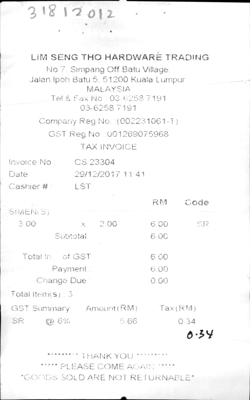

In [33]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))


## Prepare dataset for donut

As we learned in the introduction, Donut is a sequence-to-sequence model with a vision encoder and text decoder. When fine-tuning the model we want it to generate the `"text"` based on the image we pass it. Similar to NLP tasks, we have to tokenizer and preprocess the text. 
Before we can tokenize the text, we need to transform the JSON string into a Donut compatible document. 

**current JSON string**
```json
{"company": "ADVANCO COMPANY", "date": "17/01/2018", "address": "NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR", "total": "7.00"}
```

**donut document**
```json
<s></s><s_company>ADVANCO COMPANY</s_company><s_date>17/01/2018</s_date><s_address>NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR</s_address><s_total>7.00</s_total></s>
```

To easily create those documents the ClovaAI team has created a [json2token](https://github.com/clovaai/donut/blob/master/donut/model.py#L497) method, which we extract and then apply.

In [34]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")


100%|██████████| 626/626 [00:48<00:00, 12.84ex/s]


Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


In [ ]:
#TODO: resize images to a fixed size and push to the hub

The next step is to tokenize our text and encode the images into tensors. Therefore we need to load `DonutProcessor`, add our new special tokens and adjust the size of the images when process from `[1920, 2560]` to `[960, 1280]` to need less memory and have faster training.

In [35]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

In [36]:
processor.save_pretrained("processor")

Now, we can prepare our dataset, which we will use for the training later.


In [37]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
        
    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

100%|██████████| 626/626 [01:46<00:00,  5.86ex/s]


In [38]:

processed_dataset.save_to_disk("processed_dataset")

In [1]:
from datasets import load_from_disk
from transformers import DonutProcessor


processed_dataset = load_from_disk("processed_dataset")
processor = DonutProcessor.from_pretrained("processor")


/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 4. Run training and evaluation

After we have processed our dataset, we can start training our model. Therefore we first need to load our model with the `VisionEncoderDecoderModel` class.

In [2]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig


model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755888534/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


New embedding size: Embedding(57533, 1024)


In [3]:
test_ds = processed_dataset.select(range(300))


In [5]:
# # run a sample pass

# test_ds = processed_dataset.select(range(10))

# pixel_values = torch.tensor(test_ds[6]["pixel_values"]).unsqueeze(0).to(device)
# labels = torch.tensor(test_ds[6]["labels"]).unsqueeze(0).to(device)

# print(f"Pixel values: {pixel_values.shape}")
# print(f"Labels: {labels.shape}")

# # the forward function automatically creates the correct decoder_input_ids
# loss = model(pixel_values=pixel_values, labels=labels).loss

# loss

In [4]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

args = Seq2SeqTrainingArguments(
    f"test",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    logging_steps=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)


trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=test_ds,
)

Using cuda_amp half precision backend


In [5]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: target_sequence. If target_sequence are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
/home/ubuntu/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 300
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 450


Step,Training Loss
10,8.611800
20,5.570900
30,3.648200
40,3.199500
50,2.628600
60,1.786200
70,1.828000
80,1.814100
90,1.670200
100,1.109100


Saving model checkpoint to test/checkpoint-150
Configuration saved in test/checkpoint-150/config.json
Model weights saved in test/checkpoint-150/pytorch_model.bin
Deleting older checkpoint [test/checkpoint-10] due to args.save_total_limit
Saving model checkpoint to test/checkpoint-300
Configuration saved in test/checkpoint-300/config.json
Model weights saved in test/checkpoint-300/pytorch_model.bin
Deleting older checkpoint [test/checkpoint-20] due to args.save_total_limit
Saving model checkpoint to test/checkpoint-450
Configuration saved in test/checkpoint-450/config.json
Model weights saved in test/checkpoint-450/pytorch_model.bin
Deleting older checkpoint [test/checkpoint-30] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=450, training_loss=1.2699806292851765, metrics={'train_runtime': 1089.7858, 'train_samples_per_second': 0.826, 'train_steps_per_second': 0.413, 'total_flos': 1.58299902332928e+18, 'train_loss': 1.2699806292851765, 'epoch': 3.0})

In [6]:
trainer.save_model("first_run")
processor.save_pretrained("first_run")



Saving model checkpoint to first_run
Configuration saved in first_run/config.json
Model weights saved in first_run/pytorch_model.bin
Feature extractor saved in first_run/preprocessor_config.json
tokenizer config file saved in first_run/tokenizer_config.json
Special tokens file saved in first_run/special_tokens_map.json


In [9]:
dataset

NameError: name 'dataset' is not defined

In [12]:
import re
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch

processor = DonutProcessor.from_pretrained("first_run")
model = VisionEncoderDecoderModel.from_pretrained("first_run")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# load document image
image_path = "data/img/512.jpg"
image = Image.open(image_path)

# prepare decoder inputs
task_prompt = "<s>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    early_stopping=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=1,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(processor.token2json(sequence))

loading configuration file first_run/preprocessor_config.json
Feature extractor DonutFeatureExtractor {
  "do_align_long_axis": false,
  "do_normalize": true,
  "do_pad": true,
  "do_resize": true,
  "do_thumbnail": true,
  "feature_extractor_type": "DonutFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "DonutProcessor",
  "resample": 2,
  "size": [
    720,
    960
  ]
}

loading file sentencepiece.bpe.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file first_run/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "_name_or_path": "naver-clova-ix/donut-base",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "add

{'total': '26.00', 'date': '15/09/2017', 'company': 'AIK HUAT HARDWAKE'}


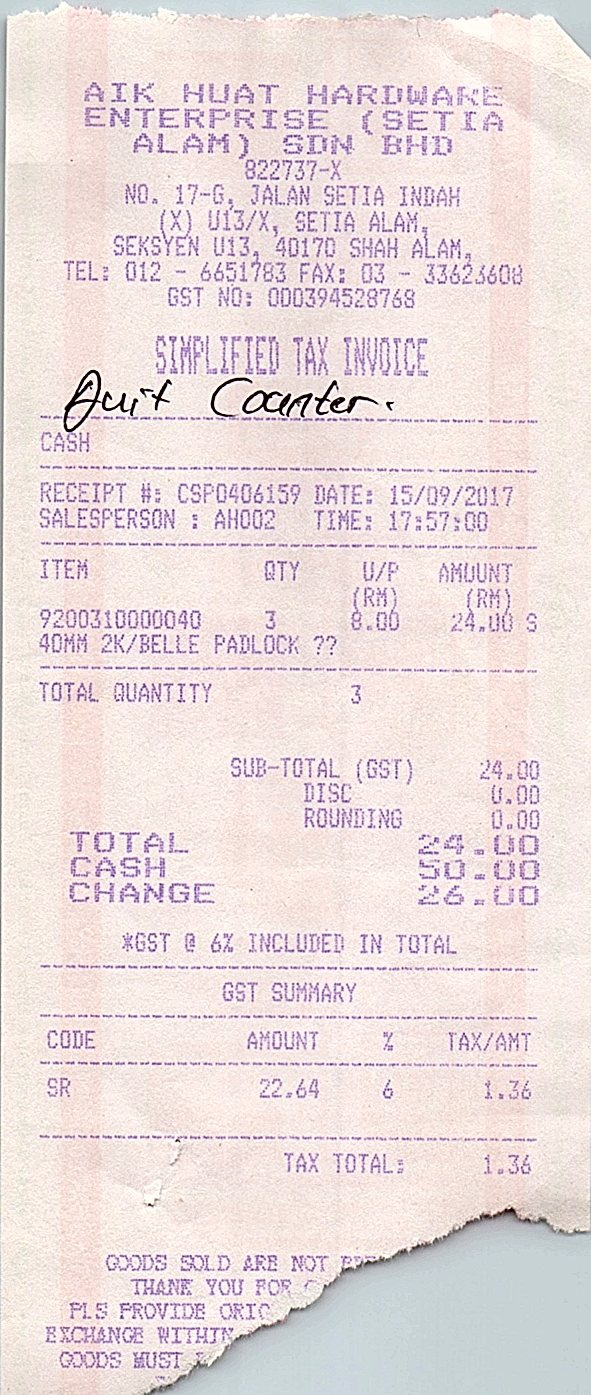

In [13]:
image